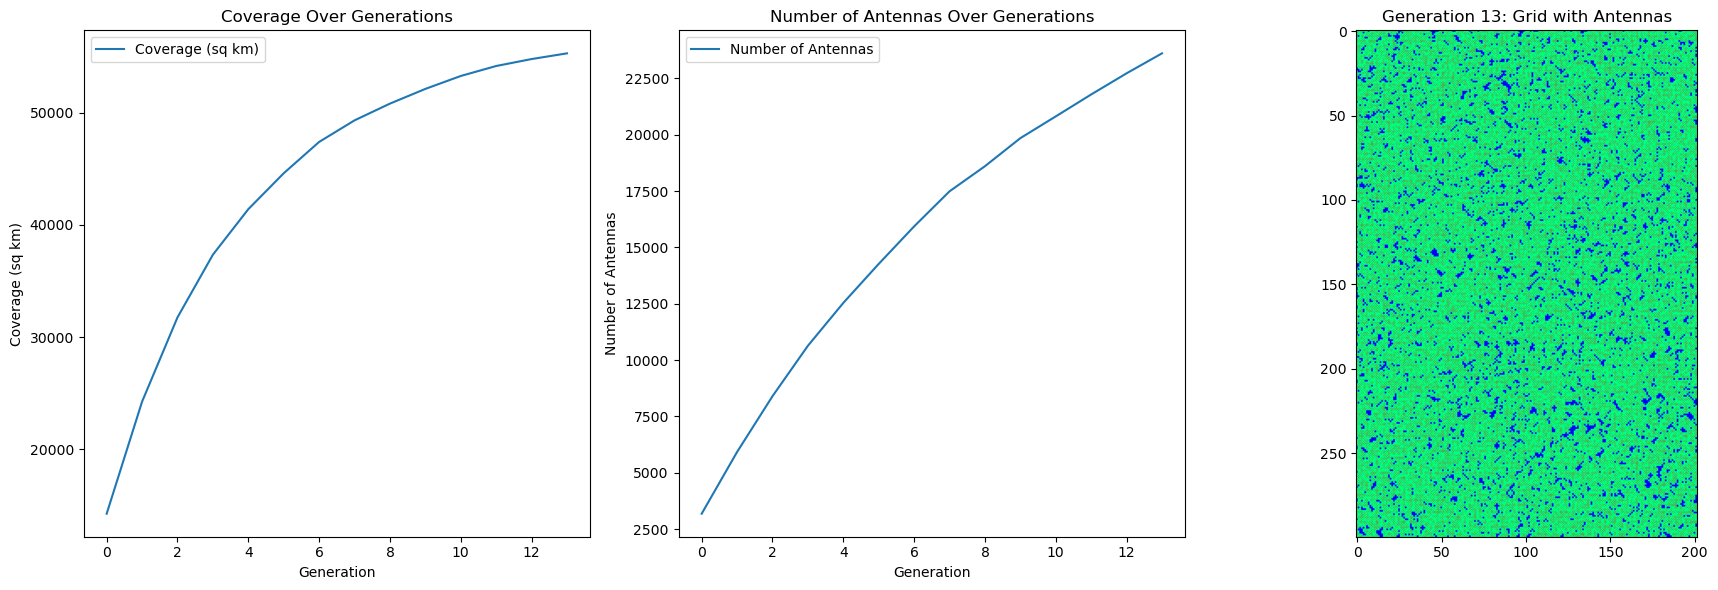

0
0
23608


KeyboardInterrupt: 

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parameters
city_dimensions = {'Madrid': (300, 202)}
population_size = 20
generations = 100
mutation_rate = 0.05
total_area = city_dimensions['Madrid'][0] * city_dimensions['Madrid'][1]
radius = 1  # Coverage radius in cells

# Helper Functions
def manhattan_distance_mask(radius):
    """Generate a Manhattan distance mask.

    Args:
        radius (int): The radius for the Manhattan distance.

    Returns:
        np.ndarray: A mask array where cells within the given radius are 1, and others are 0.
    """
    center = radius
    mask_size = 2 * radius + 1
    mask = np.zeros((mask_size, mask_size), dtype=int)
    for y in range(mask_size):
        for x in range(mask_size):
            if abs(center - x) + abs(center - y) <= radius:
                mask[y, x] = 1
    return mask

def apply_mask(grid, mask, position):
    """Apply a mask to a grid at a given position.

    Args:
        grid (np.ndarray): The grid where the mask will be applied.
        mask (np.ndarray): The mask to apply.
        position (tuple): The (x, y) position on the grid where the mask center will be placed.

    Returns:
        None
    """
    mask_size = mask.shape[0]
    radius = mask_size // 2
    y ,x = position  # Note: y is the row index, x is the column index

    # Calculate the grid slice bounds
    y_start = max(0, y - radius)
    y_end = min(grid.shape[0], y + radius + 1)
    x_start = max(0, x - radius)
    x_end = min(grid.shape[1], x + radius + 1)

    # Calculate the mask slice bounds
    mask_y_start = max(0, radius - y if y < radius else 0)
    mask_y_end = mask_size - max(0, (y + radius + 1) - grid.shape[0])
    mask_x_start = max(0, radius - x if x < radius else 0)
    mask_x_end = mask_size - max(0, (x + radius + 1) - grid.shape[1])


    # Apply the mask to the grid if there is a valid region
    if (x_end > x_start) and (y_end > y_start):
        grid[y_start:y_end, x_start:x_end] |= mask[mask_y_start:mask_y_end, mask_x_start:mask_x_end]

def compute_coverage(individual, mask):
    """Compute the coverage grid for an individual.

    Args:
        individual (np.ndarray): The individual antenna placement grid.
        mask (np.ndarray): The coverage mask to apply.

    Returns:
        np.ndarray: The coverage grid.
    """
    coverage_grid = np.zeros_like(individual)
    for y in range(individual.shape[0]):
        for x in range(individual.shape[1]):
            if individual[y, x] == 1:
                apply_mask(coverage_grid, mask, (y, x))
    return coverage_grid

def fitness(individual, mask, max_antennas = 200):
    """Calculate the fitness score of an individual.

    Args:
        individual (np.ndarray): The individual antenna placement grid.
        mask (np.ndarray): The coverage mask to apply.
        max_antennas (int): Maximum allowed number of antennas.

    Returns:
        float: The fitness score of the individual.
    """
    coverage_grid = compute_coverage(individual, mask)
    covered_area = np.sum(coverage_grid)
    num_antennas = np.sum(individual)
    coverage_rate = covered_area / total_area
    
    # Penalize excessive number of antennas
    penalty = max(0, num_antennas - max_antennas)
    
    # Fitness score with penalty
    fitness_score = coverage_rate * 100 / (num_antennas + 1) - penalty
    
    return max(0, fitness_score)
# https://www.researchgate.net/publication/221188007_A_Differential_Evolution_Based_Algorithm_to_Optimize_the_Radio_Network_Design_Problem

def initialize_population(size, dimensions, max_antennas):
    """Initialize the population with random antenna placements.

    Args:
        size (int): The population size.
        dimensions (tuple): The dimensions of the city grid.
        max_antennas (int): The maximum number of antennas to place in each grid.

    Returns:
        np.ndarray: The initialized population.
    """
    population = np.zeros((size, dimensions[0], dimensions[1]), dtype=int)
    
    for i in range(size):
        num_antennas = np.random.randint(1, max_antennas + 1)
        antenna_positions = np.random.choice(dimensions[0] * dimensions[1], num_antennas, replace=False)
        for pos in antenna_positions:
            x, y = divmod(pos, dimensions[1])
            population[i, x, y] = 1
            
    return population

def select(population, fitness_scores):
    """Select an individual from the population using tournament selection.

    Args:
        population (np.ndarray): The current population.
        fitness_scores (np.ndarray): The fitness scores of the population.

    Returns:
        np.ndarray: The selected individual.
    """
    tournament_size = 3
    idx = np.random.randint(len(population), size=tournament_size)
    best_idx = idx[np.argmax(fitness_scores[idx])]
    return population[best_idx]

def crossover(parent1, parent2):
    """Perform crossover between two parents to produce two children.

    Args:
        parent1 (np.ndarray): The first parent.
        parent2 (np.ndarray): The second parent.

    Returns:
        tuple: Two children resulting from the crossover.
    """
    point = np.random.randint(parent1.size)
    child1 = np.copy(parent1).flatten()
    child2 = np.copy(parent2).flatten()
    child1[:point], child2[:point] = child2[:point], child1[:point]
    return child1.reshape(parent1.shape), child2.reshape(parent2.shape)

def mutate(individual, mutation_rate):
    """Mutate an individual with a given mutation rate.

    Args:
        individual (np.ndarray): The individual to mutate.
        mutation_rate (float): The mutation rate.

    Returns:
        None
    """
    mutation_mask = np.random.rand(*individual.shape) < mutation_rate
    individual[mutation_mask] ^= 1

def visualize_population(grid, antennas, generation, history_coverage, history_antennas):
    """Visualize the population grid and evolution of coverage and antenna count.

    Args:
        grid (np.ndarray): The coverage grid.
        antennas (np.ndarray): The antenna placement grid.
        generation (int): The current generation number.
        history_coverage (list): The history of coverage values over generations.
        history_antennas (list): The history of antenna counts over generations.

    Returns:
        None
    """
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    
    # Coverage evolution plot
    plt.subplot(1, 3, 1)
    plt.plot(history_coverage, label='Coverage (sq km)')
    plt.title('Coverage Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Coverage (sq km)')
    plt.legend()

    # Number of antennas evolution plot
    plt.subplot(1, 3, 2)
    plt.plot(history_antennas, label='Number of Antennas')
    plt.title('Number of Antennas Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Number of Antennas')
    plt.legend()

    # Grid visualization with antennas
    plt.subplot(1, 3, 3)
    plt.imshow(grid, cmap='winter')  # Coverage in blue
    y, x = np.where(antennas == 1)
    plt.scatter(x, y, color='red', s=0.01)  # Antennas in red
    plt.title(f'Generation {generation}: Grid with Antennas')
    plt.grid(False)

    plt.tight_layout()
    plt.show()

# Initialization
population = initialize_population(population_size, city_dimensions['Madrid'],200)
mask = manhattan_distance_mask(radius)
history_coverage = []
history_antennas = []

# Main GA loop remains the same, update the call to the visualize_population function:
for generation in range(generations):
    fitness_scores = np.array([fitness(ind, mask) for ind in population])
    next_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = select(population, fitness_scores), select(population, fitness_scores)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1, mutation_rate)
        mutate(child2, mutation_rate)
        next_population.extend([child1, child2])
    population = next_population

    best_index = np.argmax(fitness_scores)
    best_individual = population[best_index]
    best_coverage_grid = compute_coverage(best_individual, mask)
    best_antenna_count = np.sum(best_individual)
    history_coverage.append(np.sum(best_coverage_grid))
    history_antennas.append(best_antenna_count)

    visualize_population(best_coverage_grid, best_individual, generation, history_coverage, history_antennas)
    print(max(fitness_scores))
    print(min(fitness_scores))
    print(best_antenna_count)
    #np.set_printoptions(threshold=np.inf)
    #print(best_coverage_grid)
